# Supplementary Figure - Vary Number of units Readout by BMI Decoder

June 24, 2022

Created as a supplement for the arXiv preprint.

The goal here is inch closer to what a real experimental setup might be like. Presumably a large population of neurons might be involved in controlling a BMI decoder. Do our results still hold even if the BMI only uses a subset of neurons in a population to control the cursor?

In order to simulate this, I've chosen to use the following approach:

* For a large population of neurons e.g. 200 units, choose a subset of 50 neurons for the BMI to use

In [1]:
folder = 'figs-2022-6-24/'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator,FixedFormatter
import matplotlib.pylab as pylab

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import interpolate # don't import stats
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy
import pickle

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [3]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories, paper_format
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


# Vary Recurrent units of RFLO with fixed M

In [4]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

seeds = [0,1,2,3]#,2,3,4,5]#,22,33,47]

# overlap_w_out0 = 0.5
# n_change_w_out0 = 50

overlaps = [0.5,0.5,0.5,0.5] # 
n_changes = [25,50,110,220] # 
n_units = [25,50,100,200] #
pretrain_durations = [2500,2000,1000,500]
train_durations = [2000,1500,1000,500]


n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7f8d0b6f3678>
>> num units: 200.00


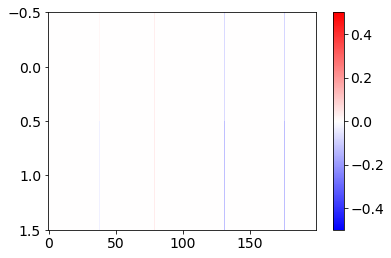

M norm: 0.48	 M angle: 0.50, 101 iterations

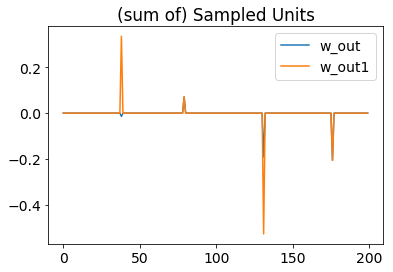


 w_out vs. w_out1 angle: 0.50

In [5]:
""" Test """
rnn_seed = 72
n_rec=200

# edge case 1 - sample all neurons
n_bmi_units=200
n_change = 200

# edge case 2 - only sample a few neurons
n_bmi_units=4
n_change = 2

overlap=0.5

params = RNNparams(n_in=4,n_rec=n_rec,n_out=2,tau_rec=10,
                       eta_in=0.1,eta_rec=0.2,eta_out=0.1,
                       sig_in=0.0,sig_rec=0.1,sig_out=0.01,
                       velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
                       rng=np.random.RandomState(rnn_seed))
params.print_params()

print('>> num units: {:.2f}'.format(n_rec))

# Initialize RNN
net0 = RNN(params)

# SET SOME COLUMNS TO ZERO, TO "SUBSAMPLE" FROM NEURAL POPULATION
w_out = np.copy(net0.w_out)
idx_zero = net0.rng.choice(np.arange(0,w_out.shape[1]),size=n_rec - n_bmi_units,replace=False)
w_out[:,idx_zero] = 0 # set select columns to zero

plt.imshow(w_out,aspect='auto',cmap='bwr',vmin=-0.5,vmax=0.5)
plt.colorbar()
plt.show()

plt.plot(np.sum(w_out,axis=0),label='w_out')
plt.title('(sum of) Sampled Units')
#plt.show()

idx_nonzero = np.argwhere(w_out[0,:] != 0).squeeze()
if idx_zero.size == 0:
    A = w_out
else:
    A = w_out[:,idx_nonzero]

# """ find overlap for active, subsampled units """
B = choose_aligned_matrix(A,n_change=n_change,overlap=overlap,rng=np.random.RandomState(rnn_seed),zero=False,tolerance=0.01,loop=10000)

w_out1 = np.copy(w_out)
if idx_zero.size==0:
    w_out1 = B
else:
    w_out1[:,idx_nonzero] = B # fill full matrix

plt.plot(np.sum(w_out1,axis=0),label='w_out1')
plt.title('(sum of) Sampled Units')
plt.legend()
plt.show()

norm, angle = return_norm_and_angle(w_out,w_out1)
print('\n w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

In [67]:
w_out_subsample[:,38]

array([ 0.01594184, -0.03010855])

In [68]:
A

array([[ 0.01594184,  0.03253316, -0.07035285, -0.07854376],
       [-0.03010855,  0.03850577, -0.12122135, -0.12745236]])

0it [00:00, ?it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb53af33b40>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 25

M norm: 0.73	 M angle: 0.50, 220 iterations
Internal Model is different subset of neurons from w_out1
M norm: 0.74	 M angle: 0.50, 30 iterations	 w_out vs. w_out1 angle: 0.50
	 w_out1 vs. w_m angle: 0.50
	 w_out vs. w_m angle: 0.30


500it [00:35, 14.10it/s]
500it [00:30, 16.38it/s]
500it [00:34, 14.21it/s]
500it [00:30, 16.50it/s]


AR early fit 0.989, late fit 0.989


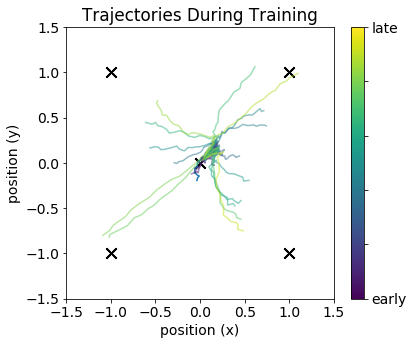

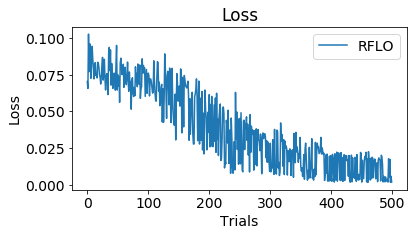

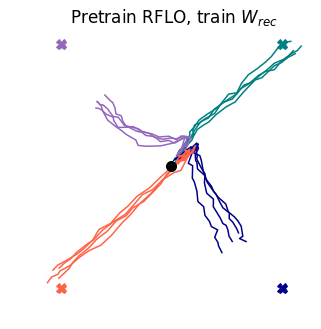

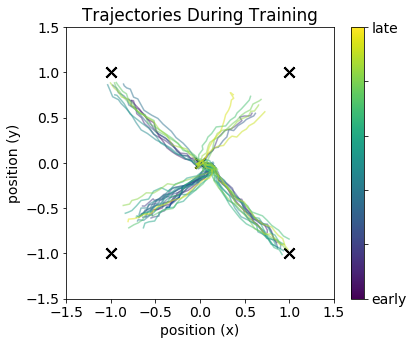

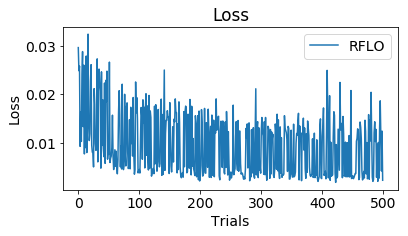

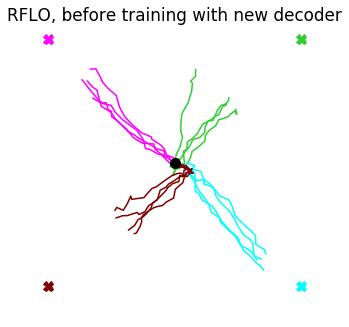

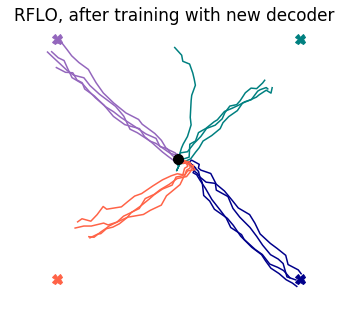

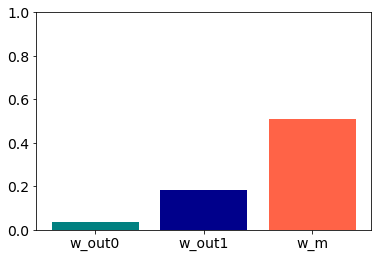

1it [00:00,  9.09it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb53af33af8>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 50

M norm: 0.81	 M angle: 0.50, 39 iterations
Internal Model is different subset of neurons from w_out1
M norm: 0.79	 M angle: 0.51, 10 iterations	 w_out vs. w_out1 angle: 0.50
	 w_out1 vs. w_m angle: 0.51
	 w_out vs. w_m angle: 0.21


500it [00:37,  9.87it/s]
500it [00:30, 16.50it/s]
500it [00:35, 14.35it/s]
500it [00:30, 16.67it/s]


AR early fit 0.981, late fit 0.983


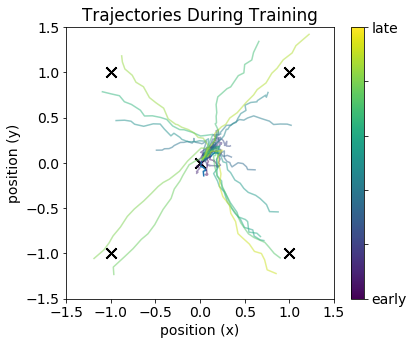

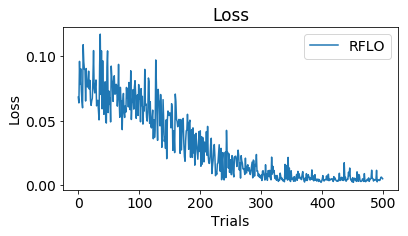

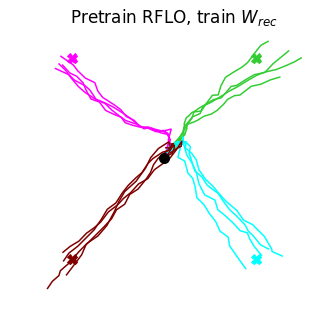

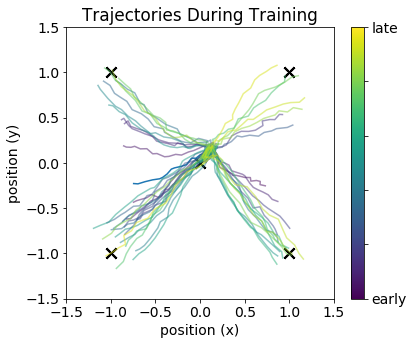

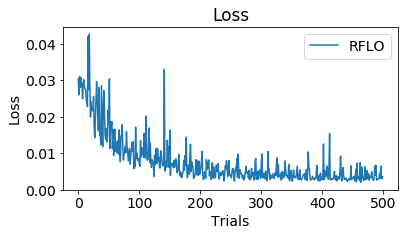

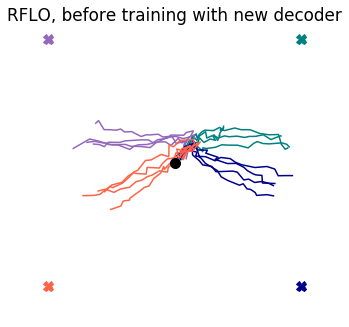

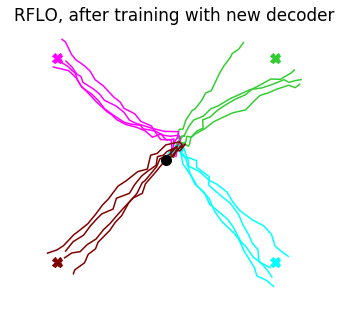

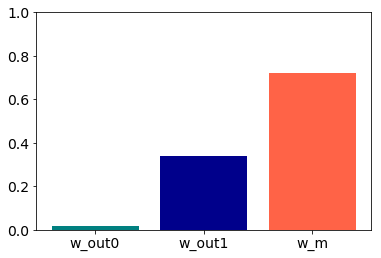

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb516a13870>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 100

NO OVERLAP M angle: 0.61, 5033 iterations

0it [00:00, ?it/s]

M norm: 0.98	 M angle: 0.51, 346 iterations
Internal Model is different subset of neurons from w_out1
M norm: 0.96	 M angle: 0.49, 5 iterations	 w_out vs. w_out1 angle: 0.50
	 w_out1 vs. w_m angle: 0.49
	 w_out vs. w_m angle: 0.21


500it [00:34, 14.59it/s]
500it [00:30, 16.62it/s]
500it [00:34, 14.29it/s]
500it [00:30, 16.70it/s]


AR early fit 0.961, late fit 0.971


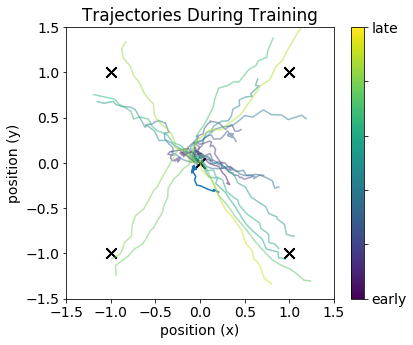

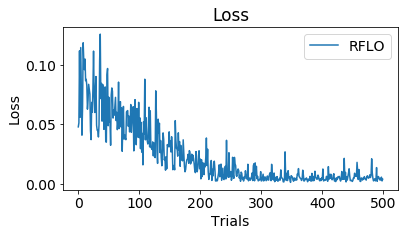

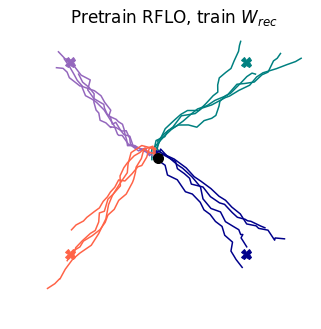

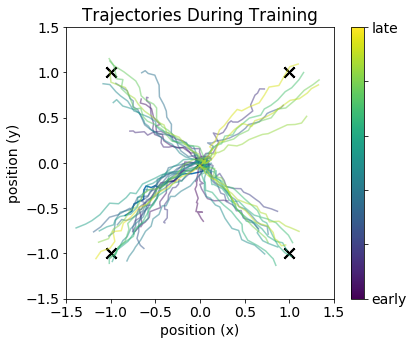

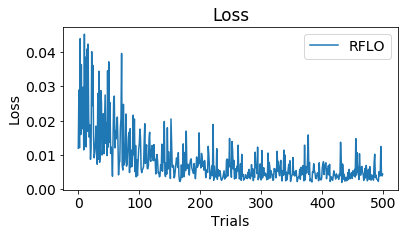

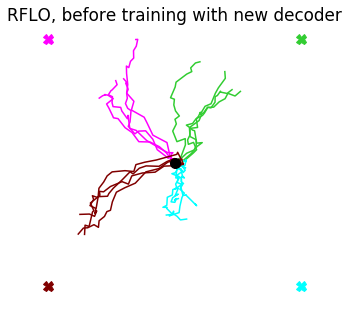

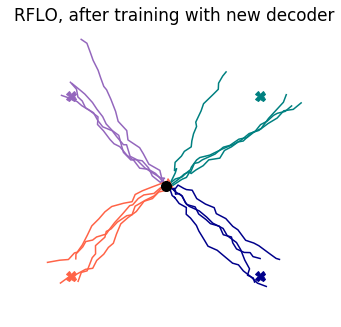

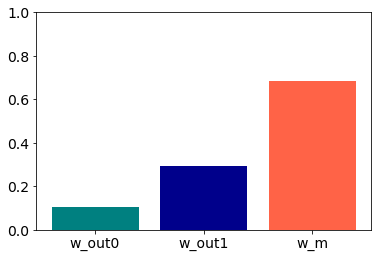

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb53b208900>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 200

NO OVERLAP M angle: 0.62, 20098 iterations

0it [00:00, ?it/s]

M norm: 1.14	 M angle: 0.49, 0 iterations
Internal Model is different subset of neurons from w_out1
M norm: 1.14	 M angle: 0.49, 0 iterations	 w_out vs. w_out1 angle: 0.51
	 w_out1 vs. w_m angle: 0.49
	 w_out vs. w_m angle: 0.21


500it [00:34, 14.50it/s]
500it [00:30, 16.68it/s]
500it [00:34, 14.36it/s]
500it [00:30, 16.57it/s]


AR early fit 0.945, late fit 0.963


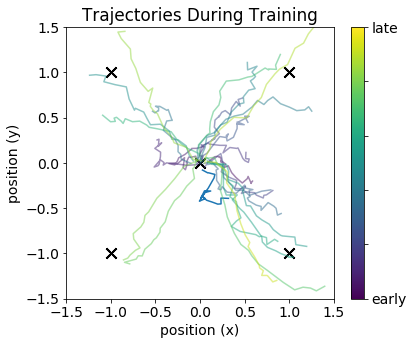

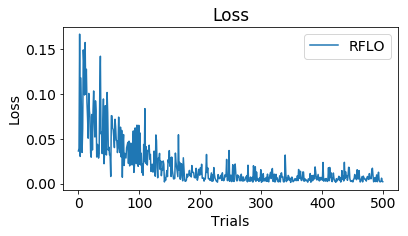

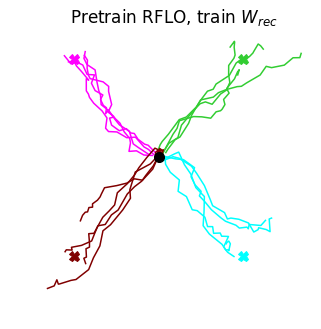

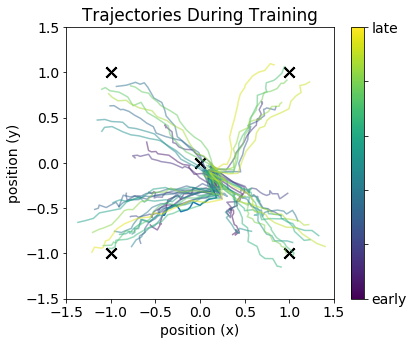

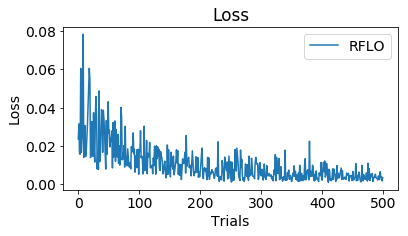

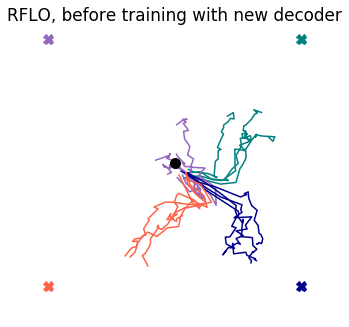

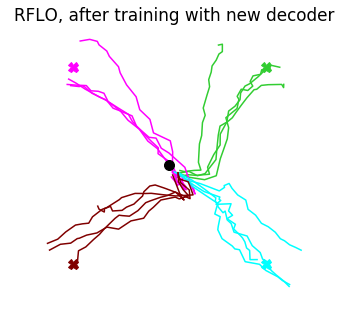

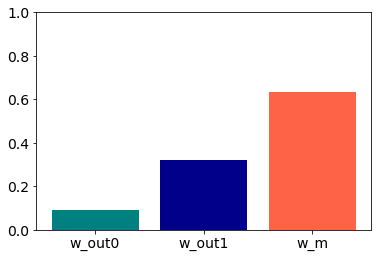

1it [00:00,  7.99it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb53b208bd0>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 25

M norm: 0.73	 M angle: 0.50, 24 iterations
Internal Model is different subset of neurons from w_out1
M norm: 0.74	 M angle: 0.51, 37 iterations	 w_out vs. w_out1 angle: 0.49
	 w_out1 vs. w_m angle: 0.51
	 w_out vs. w_m angle: 0.17


500it [00:34, 14.38it/s]
500it [00:30, 16.54it/s]
500it [00:34, 14.42it/s]
500it [00:30, 16.71it/s]


AR early fit 0.989, late fit 0.989


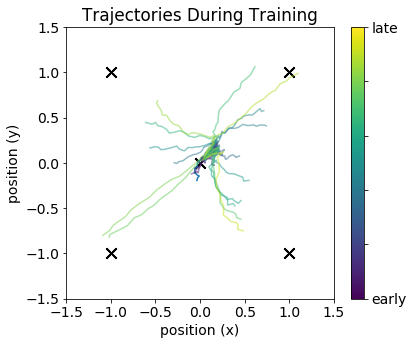

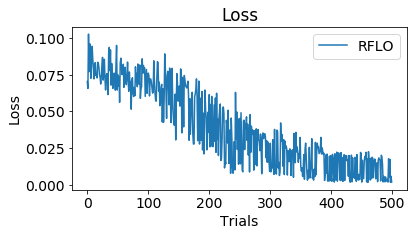

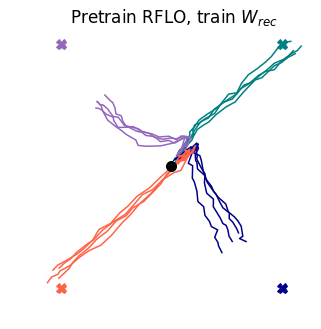

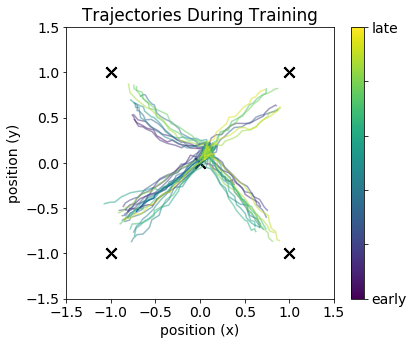

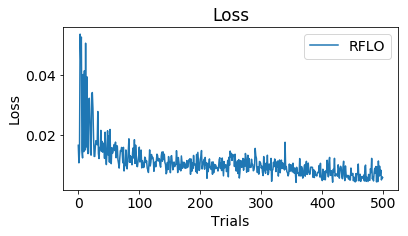

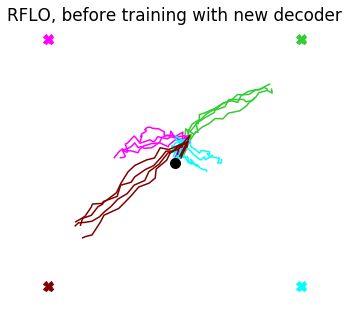

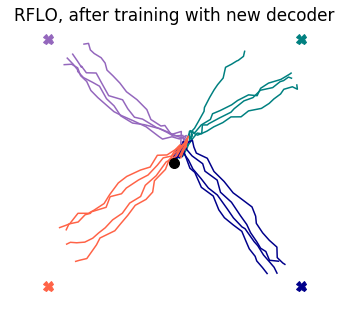

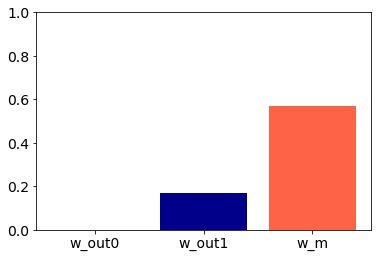

1it [00:00,  8.73it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb53c48d480>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 50

M norm: 0.78	 M angle: 0.51, 8 iterations
Internal Model is different subset of neurons from w_out1
M norm: 0.81	 M angle: 0.49, 2 iterations	 w_out vs. w_out1 angle: 0.49
	 w_out1 vs. w_m angle: 0.49
	 w_out vs. w_m angle: 0.21


500it [00:34, 14.31it/s]
500it [00:34, 11.86it/s]
500it [00:35, 14.06it/s]
500it [00:30, 16.27it/s]


AR early fit 0.981, late fit 0.984


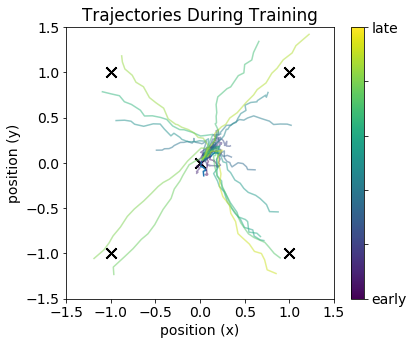

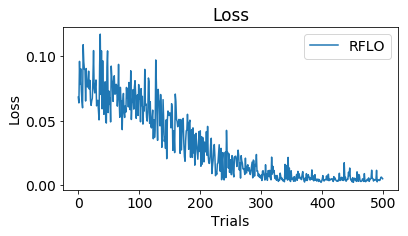

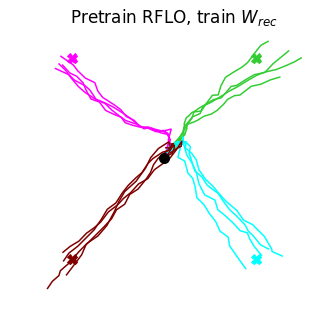

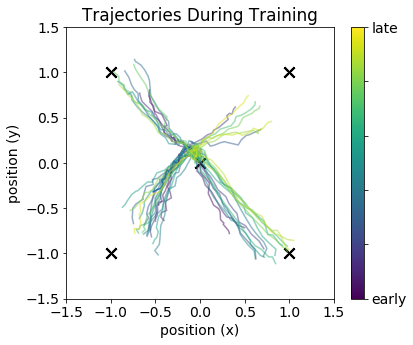

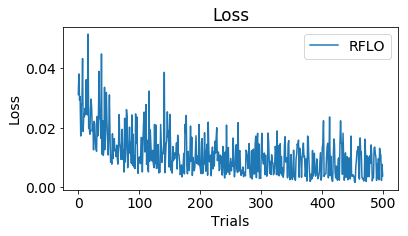

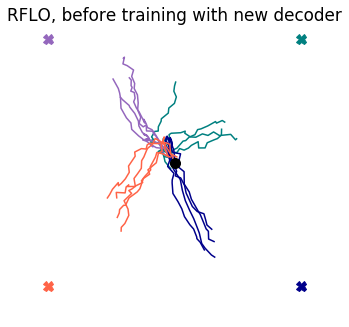

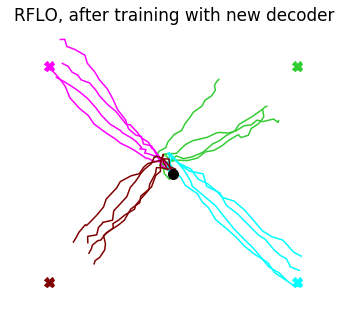

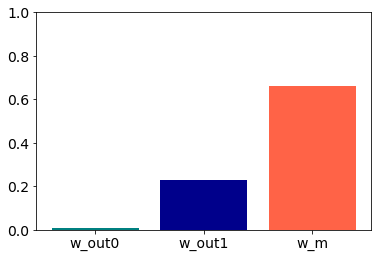

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb53c5496c0>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 100

NO OVERLAP M angle: 0.56, 203 iterations

0it [00:00, ?it/s]

M norm: 0.98	 M angle: 0.50, 748 iterations
Internal Model is different subset of neurons from w_out1
M norm: 0.93	 M angle: 0.50, 1 iterations	 w_out vs. w_out1 angle: 0.51
	 w_out1 vs. w_m angle: 0.50
	 w_out vs. w_m angle: 0.29


500it [00:36, 14.64it/s]
500it [00:30, 16.51it/s]
500it [00:35, 14.13it/s]
500it [00:30, 16.46it/s]


AR early fit 0.961, late fit 0.971


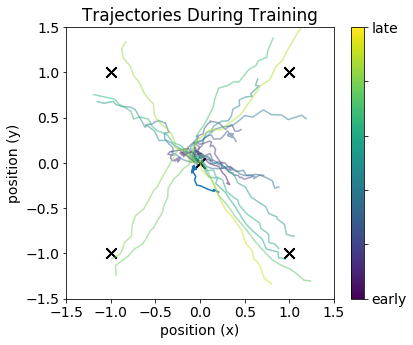

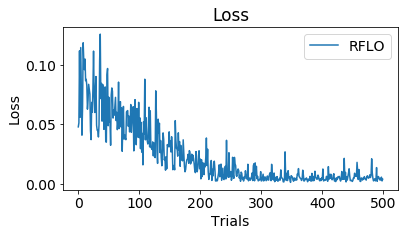

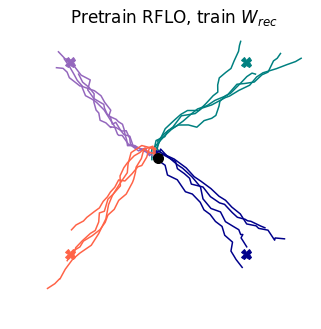

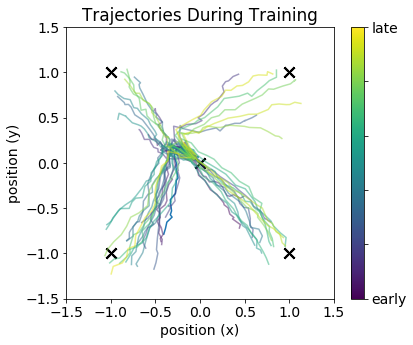

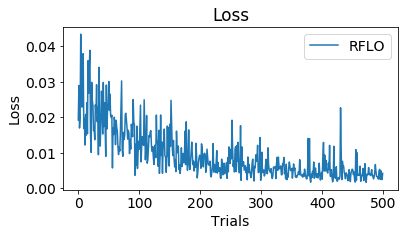

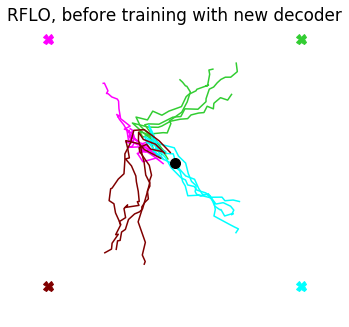

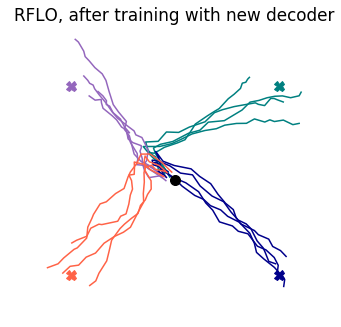

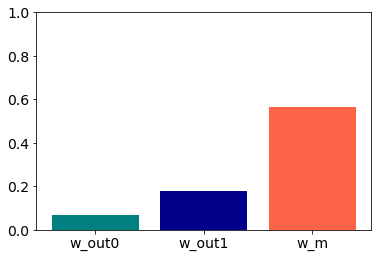

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb53c5499d8>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 200

NO OVERLAP M angle: 0.55, 261 iterations

0it [00:00, ?it/s]

M norm: 1.14	 M angle: 0.50, 289 iterations
Internal Model is different subset of neurons from w_out1
M norm: 1.14	 M angle: 0.50, 289 iterations	 w_out vs. w_out1 angle: 0.50
	 w_out1 vs. w_m angle: 0.50
	 w_out vs. w_m angle: 0.25


500it [00:34, 14.22it/s]
500it [00:30, 16.07it/s]
500it [00:34, 14.44it/s]
500it [00:30, 16.63it/s]


AR early fit 0.945, late fit 0.961


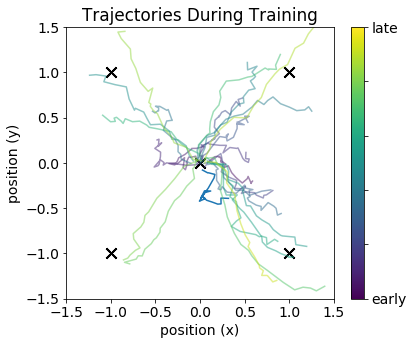

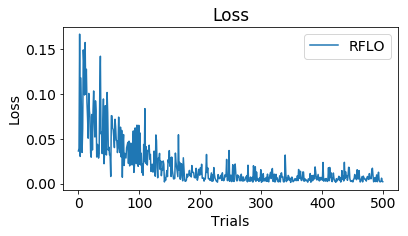

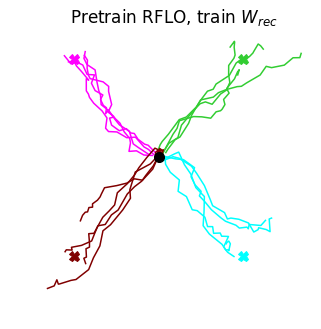

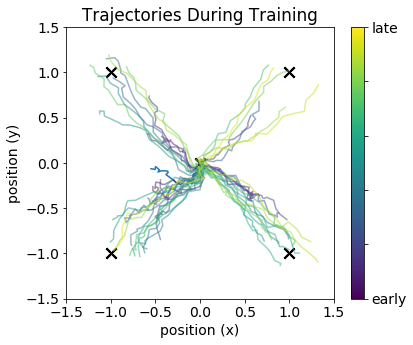

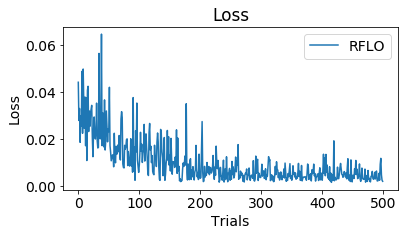

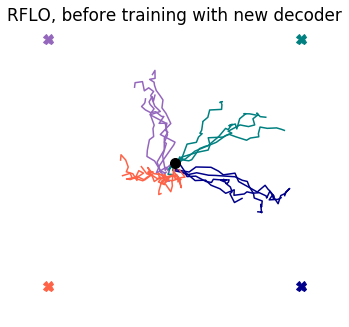

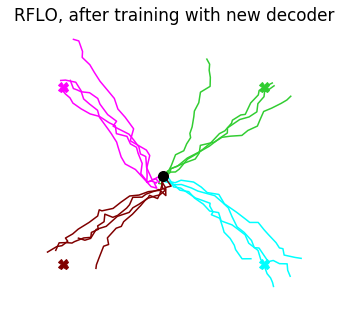

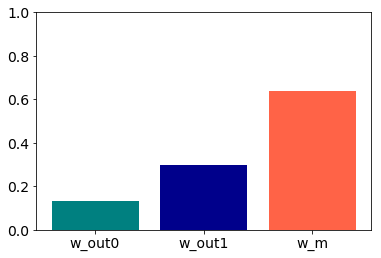

1it [00:00,  9.24it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb51a07f9d8>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 25

M norm: 0.64	 M angle: 0.50, 13 iterations
Internal Model is different subset of neurons from w_out1
M norm: 0.72	 M angle: 0.49, 5 iterations	 w_out vs. w_out1 angle: 0.50
	 w_out1 vs. w_m angle: 0.49
	 w_out vs. w_m angle: 0.23


500it [00:34, 14.33it/s]
500it [00:30, 15.88it/s]
500it [00:34, 14.34it/s]
500it [00:30, 16.71it/s]


AR early fit 0.989, late fit 0.989


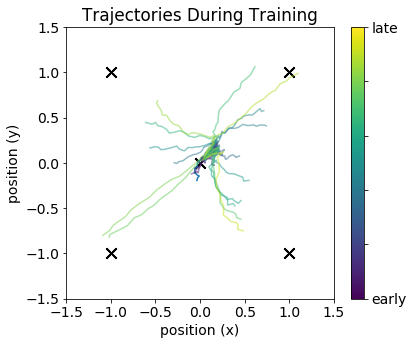

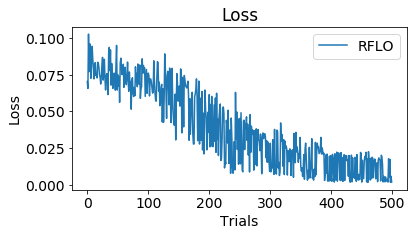

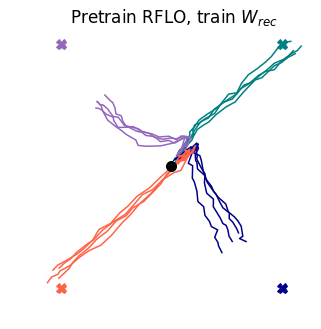

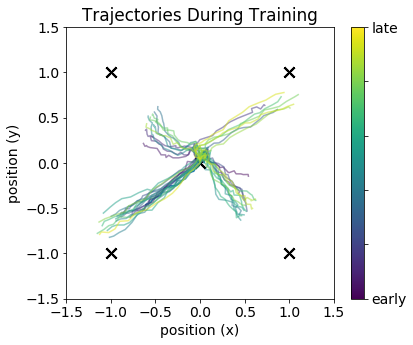

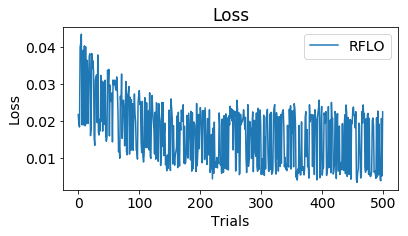

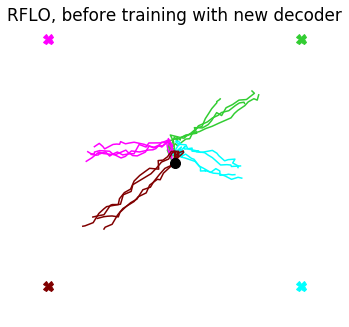

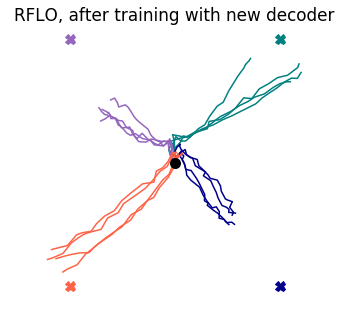

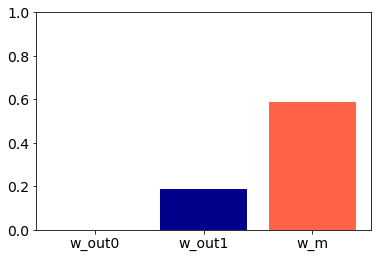

1it [00:00,  9.34it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb53d163678>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 50

M norm: 0.85	 M angle: 0.50, 14 iterations
Internal Model is different subset of neurons from w_out1
M norm: 0.84	 M angle: 0.50, 5 iterations	 w_out vs. w_out1 angle: 0.49
	 w_out1 vs. w_m angle: 0.50
	 w_out vs. w_m angle: 0.24


500it [00:36, 13.78it/s]
500it [00:30, 16.74it/s]
500it [00:34, 14.35it/s]
500it [00:30, 16.40it/s]


AR early fit 0.981, late fit 0.983


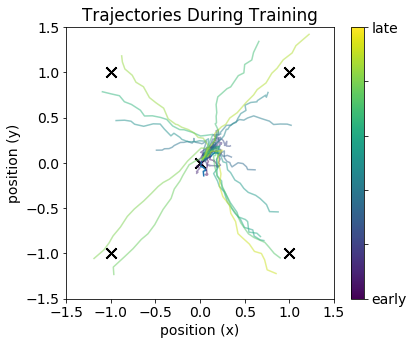

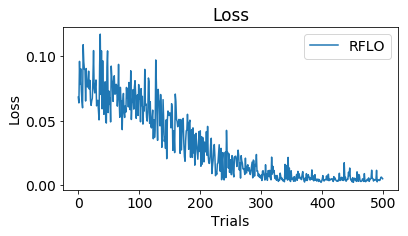

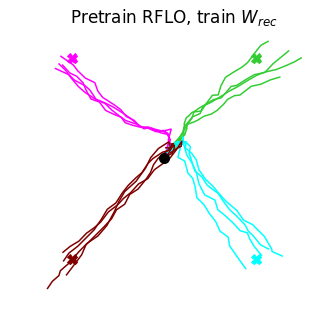

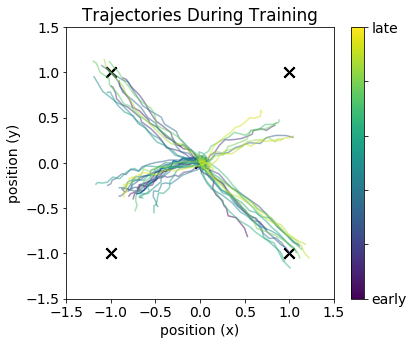

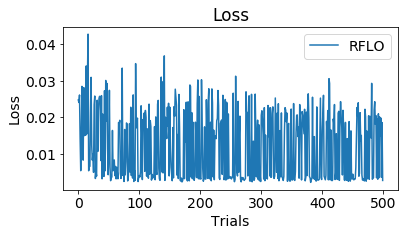

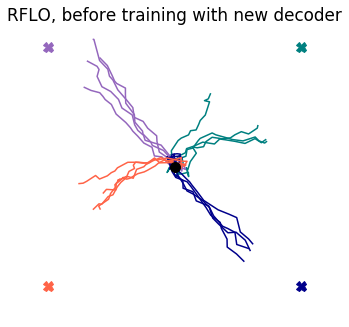

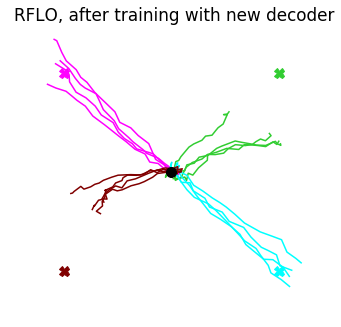

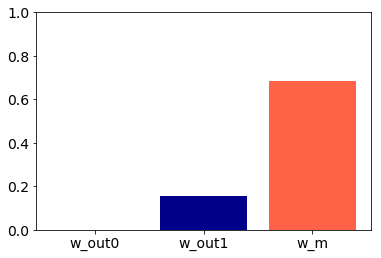

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb51877d240>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 100

NO OVERLAP M angle: 0.69, 1708 iterations

0it [00:00, ?it/s]

M norm: 0.93	 M angle: 0.50, 283 iterations
Internal Model is different subset of neurons from w_out1
M norm: 0.94	 M angle: 0.49, 5 iterations	 w_out vs. w_out1 angle: 0.51
	 w_out1 vs. w_m angle: 0.49
	 w_out vs. w_m angle: 0.21


500it [00:34, 14.33it/s]
500it [00:30, 16.75it/s]
500it [00:35, 14.06it/s]
500it [00:30, 16.61it/s]


AR early fit 0.961, late fit 0.973


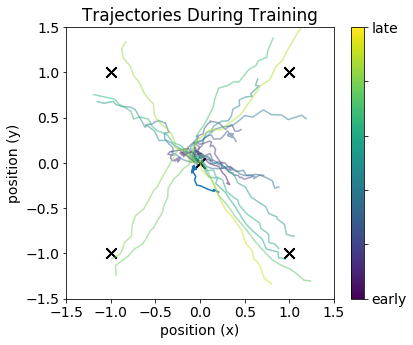

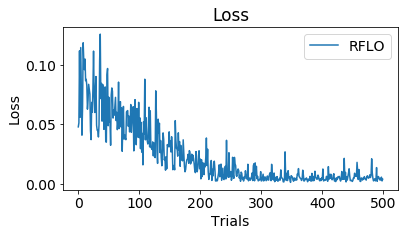

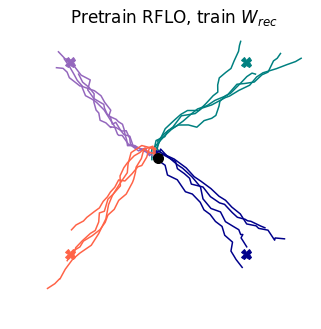

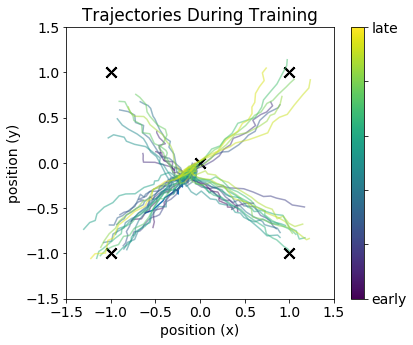

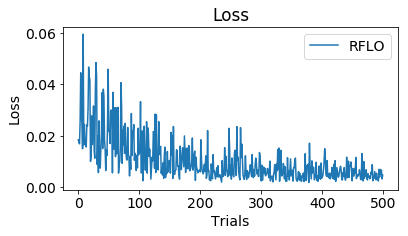

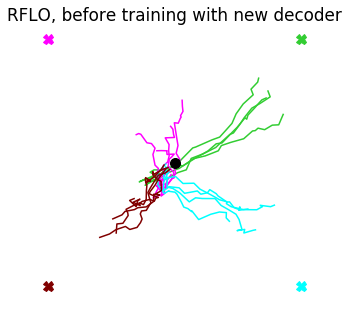

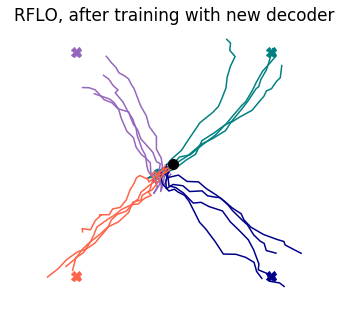

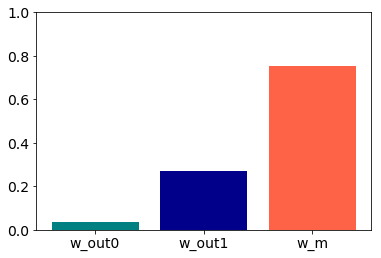

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb53c5da480>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 200

NO OVERLAP M angle: 0.62, 1219 iterations

0it [00:00, ?it/s]

M norm: 1.10	 M angle: 0.51, 82 iterations
Internal Model is different subset of neurons from w_out1
M norm: 1.10	 M angle: 0.51, 82 iterations	 w_out vs. w_out1 angle: 0.50
	 w_out1 vs. w_m angle: 0.51
	 w_out vs. w_m angle: 0.19


500it [00:34, 13.25it/s]
500it [00:30, 16.19it/s]
500it [00:36, 14.35it/s]
500it [00:30, 16.66it/s]


AR early fit 0.945, late fit 0.962


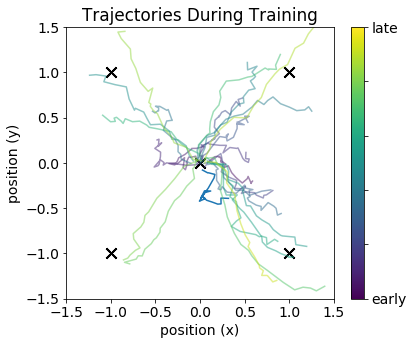

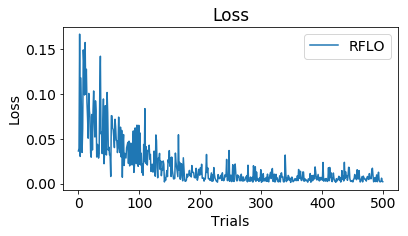

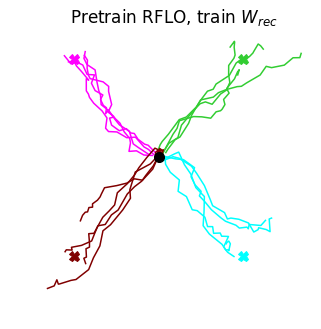

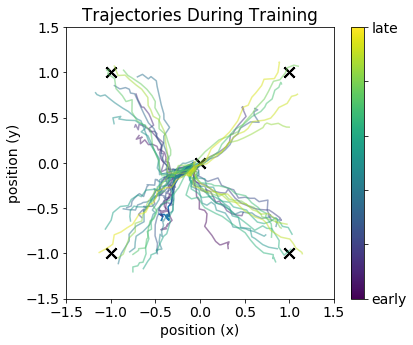

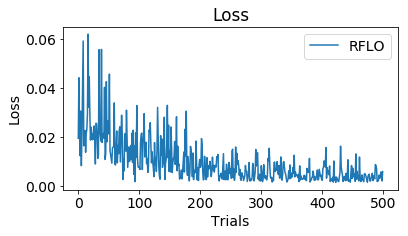

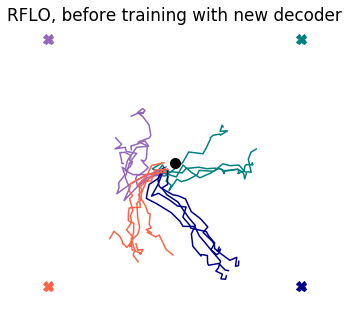

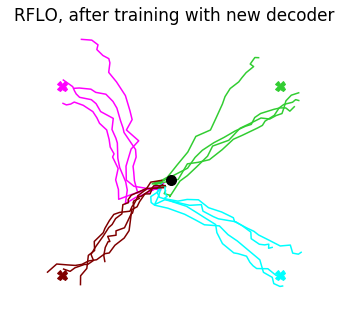

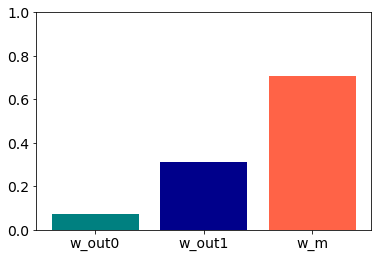

1it [00:00,  8.99it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb516eb89d8>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 25

M norm: 0.71	 M angle: 0.49, 23 iterations
Internal Model is different subset of neurons from w_out1
M norm: 0.70	 M angle: 0.50, 20 iterations	 w_out vs. w_out1 angle: 0.50
	 w_out1 vs. w_m angle: 0.50
	 w_out vs. w_m angle: 0.13


500it [00:34, 14.42it/s]
500it [00:30, 16.67it/s]
500it [00:34, 13.68it/s]
500it [00:30, 16.40it/s]


AR early fit 0.989, late fit 0.989


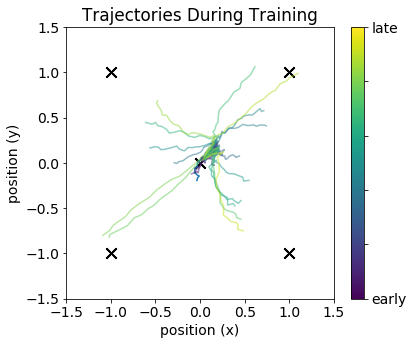

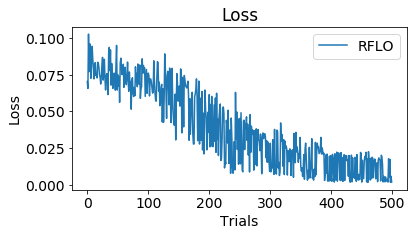

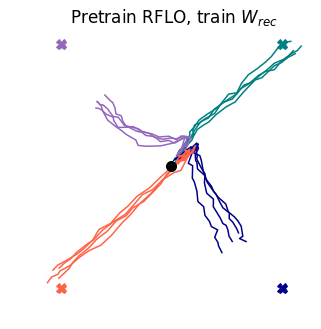

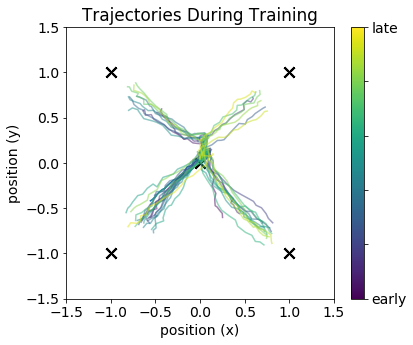

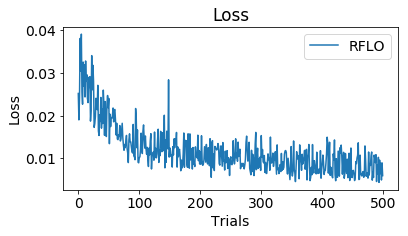

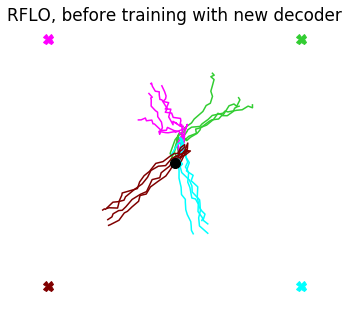

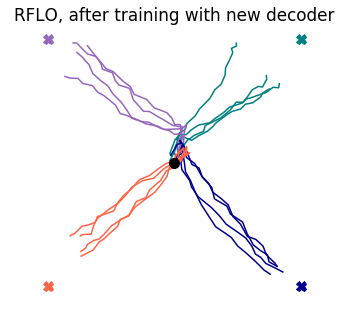

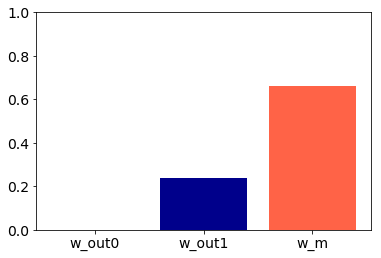

1it [00:00,  9.26it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb516eb8a20>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 50

M norm: 0.81	 M angle: 0.50, 12 iterations
Internal Model is different subset of neurons from w_out1
M norm: 0.82	 M angle: 0.50, 9 iterations	 w_out vs. w_out1 angle: 0.51
	 w_out1 vs. w_m angle: 0.50
	 w_out vs. w_m angle: 0.31


500it [00:48, 10.36it/s]
500it [00:44, 11.72it/s]
500it [00:41, 14.21it/s]
500it [00:30, 16.59it/s]


AR early fit 0.981, late fit 0.985


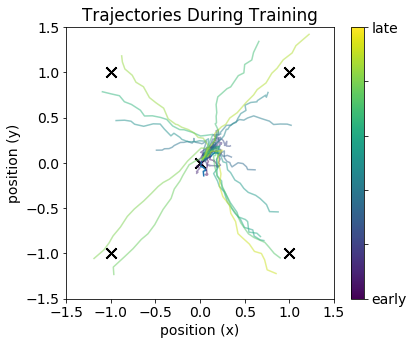

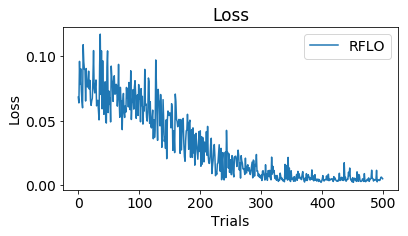

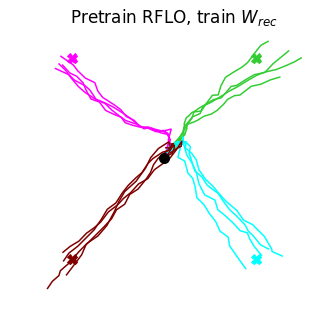

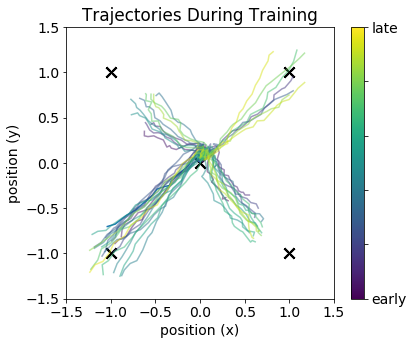

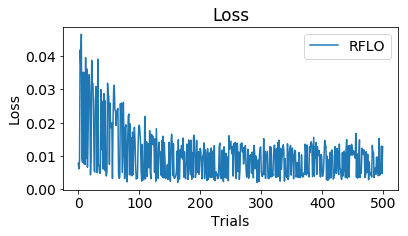

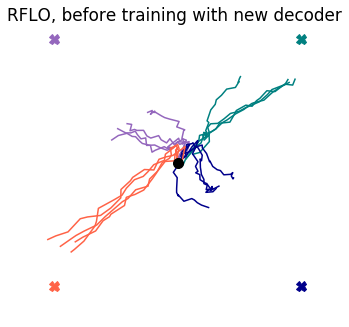

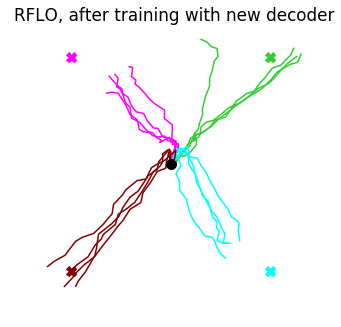

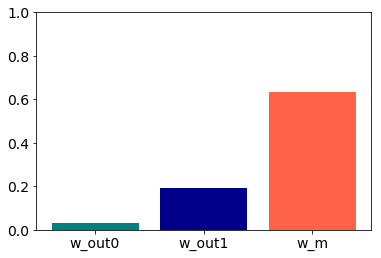

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb53c6fa048>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 100

NO OVERLAP M angle: 0.67, 3981 iterations

0it [00:00, ?it/s]

M norm: 0.98	 M angle: 0.51, 219 iterations
Internal Model is different subset of neurons from w_out1
M norm: 0.97	 M angle: 0.49, 6 iterations	 w_out vs. w_out1 angle: 0.50
	 w_out1 vs. w_m angle: 0.49
	 w_out vs. w_m angle: 0.32


500it [00:36, 14.51it/s]
500it [00:30, 16.56it/s]
500it [00:35, 13.01it/s]
500it [00:30, 15.50it/s]


AR early fit 0.961, late fit 0.971


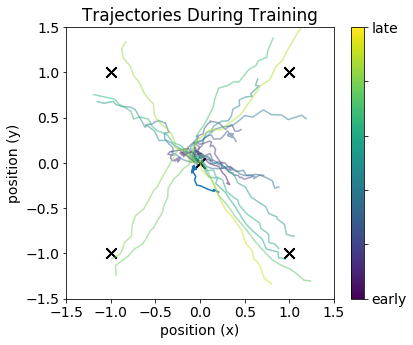

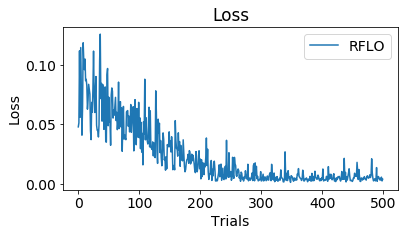

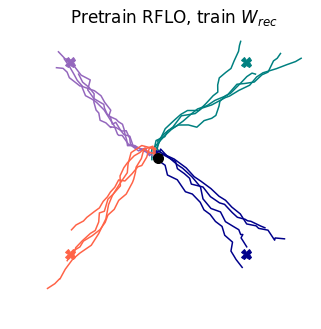

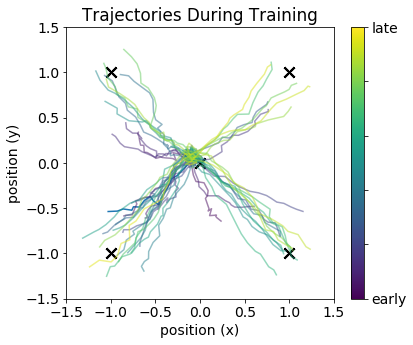

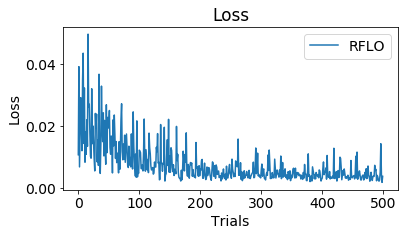

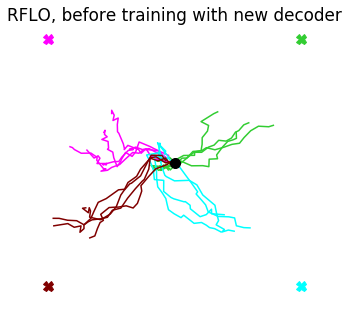

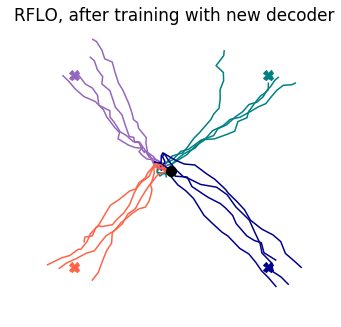

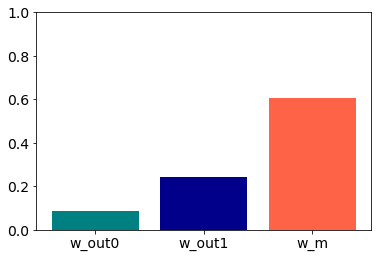

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb51880ff30>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 200

NO OVERLAP M angle: 0.65, 59242 iterations

0it [00:00, ?it/s]

M norm: 1.10	 M angle: 0.51, 48 iterations
Internal Model is different subset of neurons from w_out1
M norm: 1.10	 M angle: 0.51, 48 iterations	 w_out vs. w_out1 angle: 0.51
	 w_out1 vs. w_m angle: 0.51
	 w_out vs. w_m angle: 0.18


500it [00:34, 14.36it/s]
500it [00:30, 15.76it/s]
500it [00:34, 14.40it/s]
500it [00:30, 16.60it/s]


AR early fit 0.945, late fit 0.959


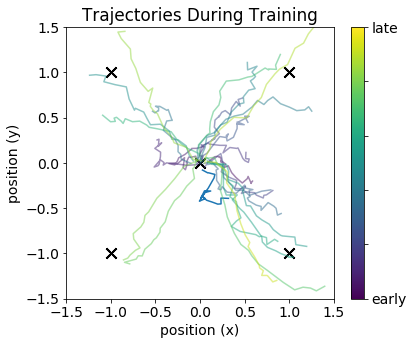

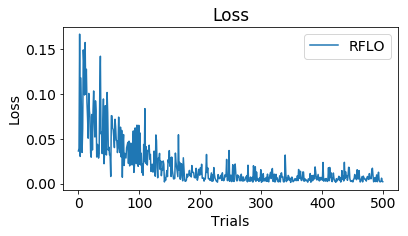

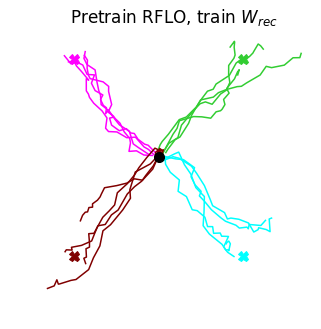

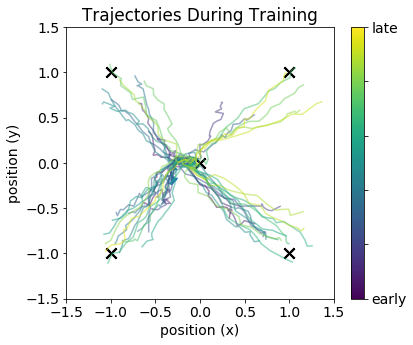

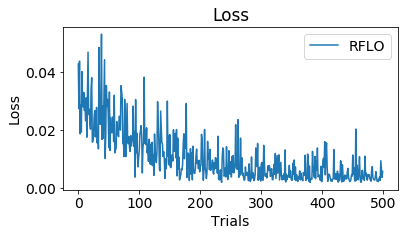

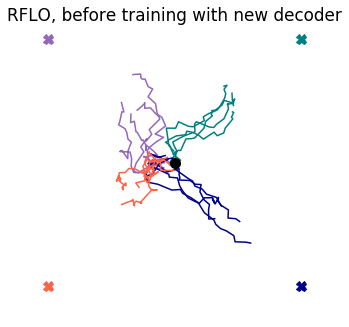

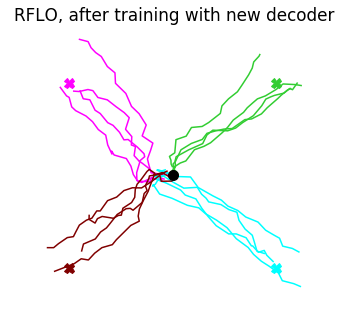

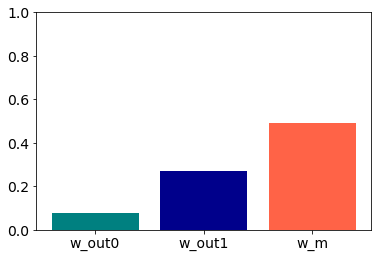

1it [00:00,  8.62it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb516b60318>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 25

M norm: 0.74	 M angle: 0.49, 41 iterations
Internal Model is different subset of neurons from w_out1
M norm: 0.77	 M angle: 0.51, 24 iterations	 w_out vs. w_out1 angle: 0.50
	 w_out1 vs. w_m angle: 0.51
	 w_out vs. w_m angle: 0.38


500it [00:36, 13.58it/s]
500it [00:30, 16.42it/s]
500it [00:35, 14.36it/s]
500it [00:30, 13.20it/s]


AR early fit 0.989, late fit 0.989


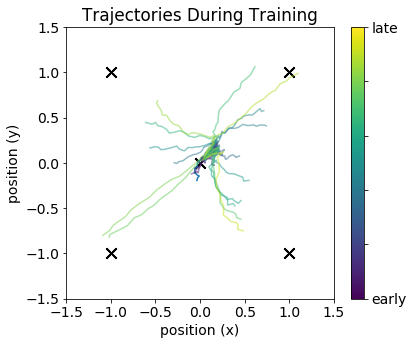

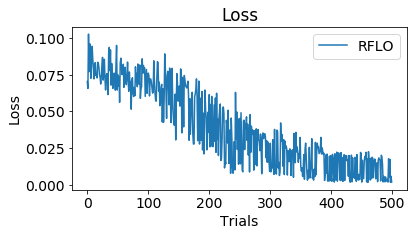

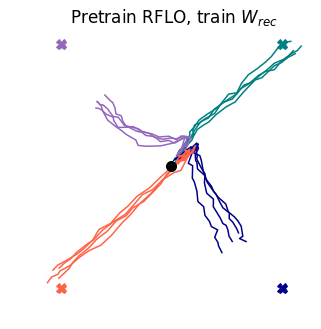

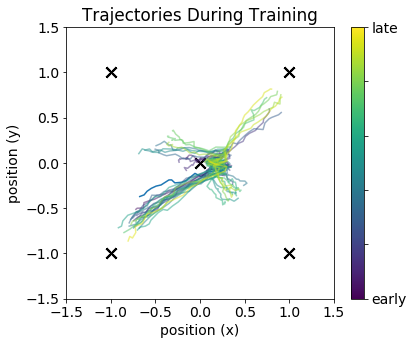

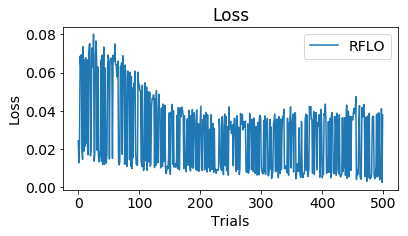

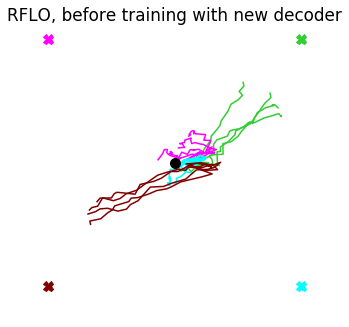

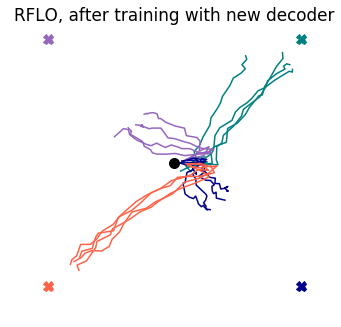

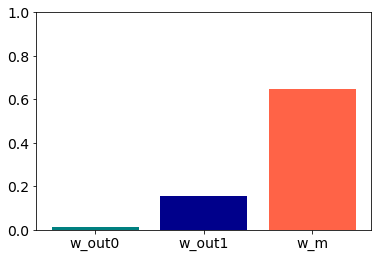

1it [00:00,  8.40it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb51a103240>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 50

M norm: 0.82	 M angle: 0.50, 69 iterations
Internal Model is different subset of neurons from w_out1
M norm: 0.82	 M angle: 0.50, 8 iterations	 w_out vs. w_out1 angle: 0.50
	 w_out1 vs. w_m angle: 0.50
	 w_out vs. w_m angle: 0.26


500it [00:35, 14.27it/s]
500it [00:30, 16.67it/s]
500it [00:34, 14.33it/s]
500it [00:30, 16.42it/s]


AR early fit 0.981, late fit 0.983


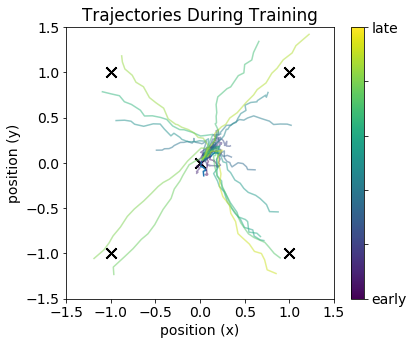

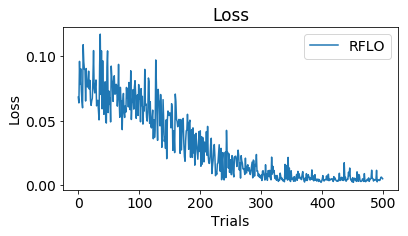

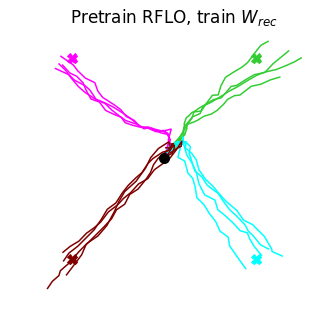

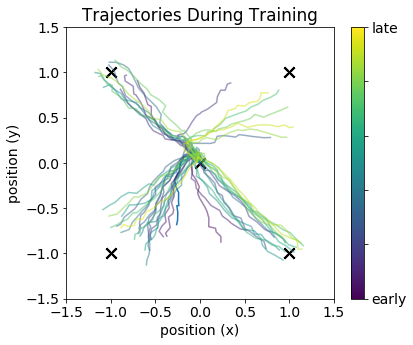

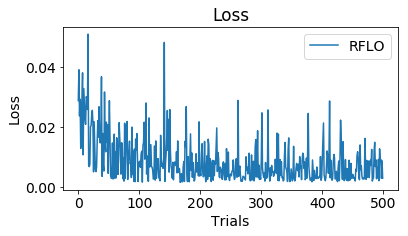

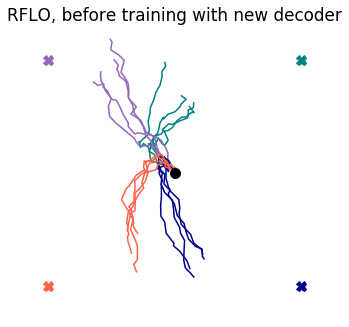

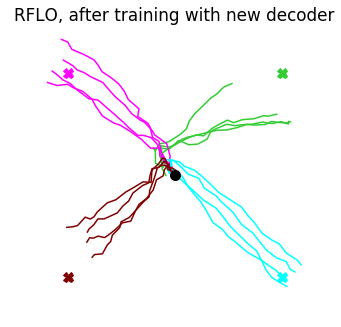

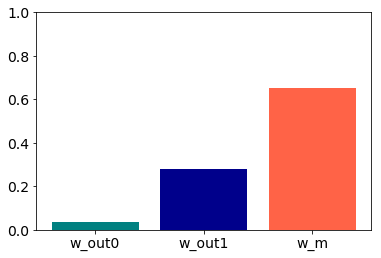

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb516a60900>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 100

NO OVERLAP M angle: 0.64, 534 iterations

0it [00:00, ?it/s]

M norm: 0.95	 M angle: 0.51, 1266 iterations
Internal Model is different subset of neurons from w_out1
M norm: 0.96	 M angle: 0.50, 0 iterations	 w_out vs. w_out1 angle: 0.50
	 w_out1 vs. w_m angle: 0.50
	 w_out vs. w_m angle: 0.30


500it [00:35, 14.15it/s]
500it [00:30, 16.70it/s]
500it [00:34, 14.19it/s]
500it [00:30, 16.45it/s]


AR early fit 0.961, late fit 0.972


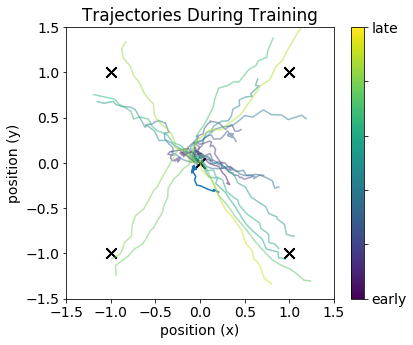

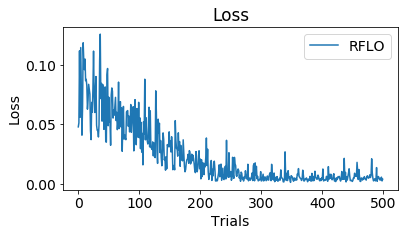

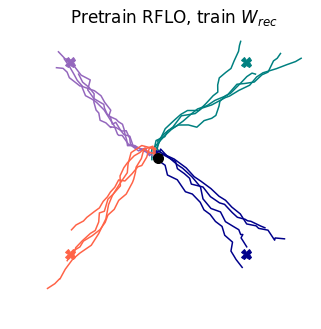

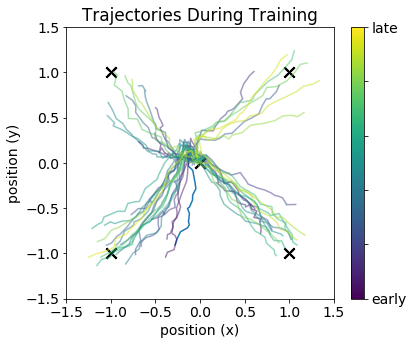

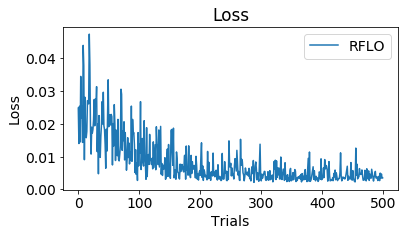

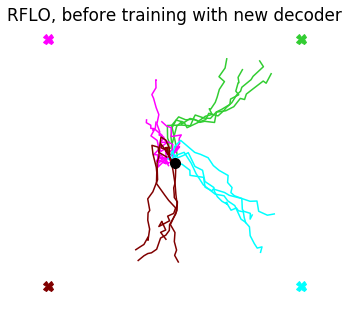

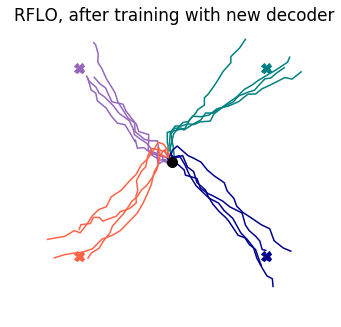

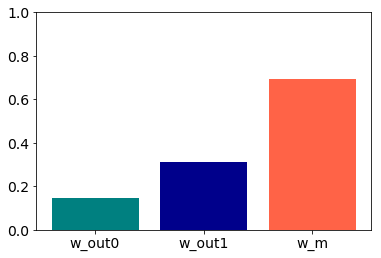

1it [00:00,  7.50it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb517682558>
>> num units: 200.00

NUMBER OF SAMPLED BMI UNITS: 200

M norm: 1.11	 M angle: 0.51, 30 iterations
Internal Model is different subset of neurons from w_out1
M norm: 1.11	 M angle: 0.51, 30 iterations	 w_out vs. w_out1 angle: 0.50
	 w_out1 vs. w_m angle: 0.51
	 w_out vs. w_m angle: 0.21


500it [00:36, 13.68it/s]
500it [00:30, 16.68it/s]
500it [00:35, 14.01it/s]
500it [00:30, 16.22it/s]


AR early fit 0.945, late fit 0.963


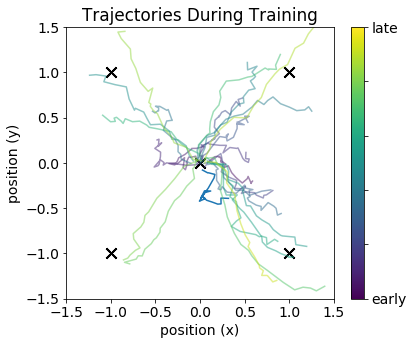

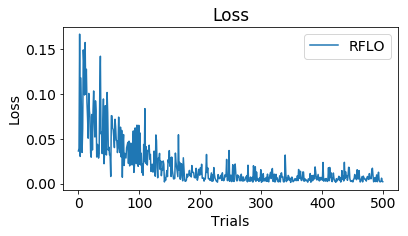

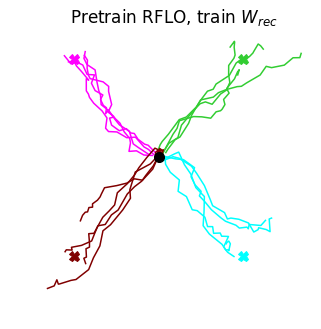

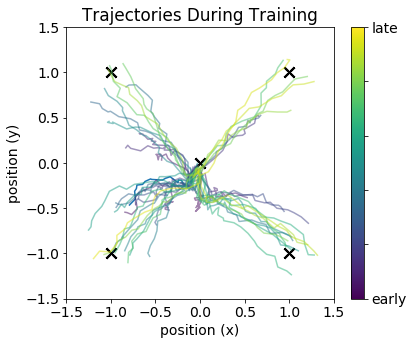

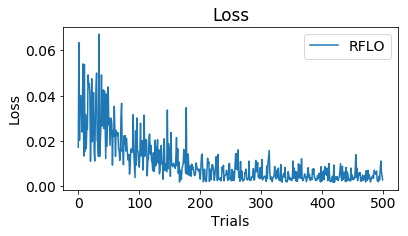

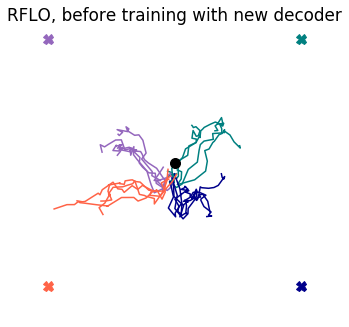

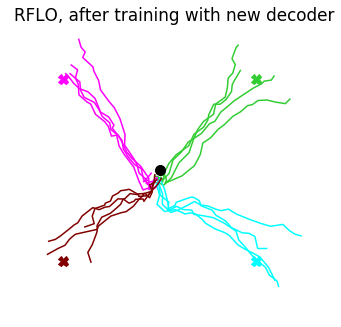

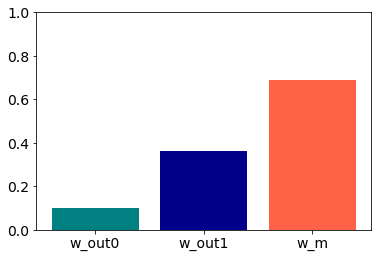

In [5]:


rnn_seed = 72

test_duration = 500







""" Average over multiple seeds """
# seeds = [0,1,2,3]#,2,3,4,5]#,22,33,47]

# # overlap_w_out0 = 0.5
# # n_change_w_out0 = 50

# overlaps = [0.5,0.5,0.5,0.5] # 
# n_changes = [25,50,110,220] # 
# n_units = [25,50,100,200] #
# pretrain_durations = [2500,2000,1000,500]
# train_durations = [2000,1500,1000,500]

seeds = [0,2,3,4,5]#,22,33,47]

# overlap_w_out0 = 0.5
# n_change_w_out0 = 50

# factors to select here ar n_bmi_units and n_change

n_rec=200
overlaps = [0.5,0.5,0.5,0.5] # 

# choose different subset of neurons

w_m_same_neurons = False
n_changes = [15,40,80,200] # 
n_change_w_m = 200 # only in case of w_m_same_neurons= False
n_bmi_units = [25,50,100,200] # number of units read out by BMI 

# w_m_same_neurons = True
# n_changes = [15,40,80,200] # 
# n_bmi_units = [25,50,100,200] # number of units read out by BMI

pretrain_durations = [500,500,500,500]
train_durations = [500,500,500,500]



stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corrcoef'] = []

stats['seeds'] = seeds
stats['overlaps'] = overlaps
stats['n_changes'] = n_changes
stats['n_bmi_units'] = n_bmi_units
# stats['overlap_w_out0'] = overlap_w_out0
# stats['n_change_w_out0'] = n_change_w_out0
stats['frac_on'] = frac_on

stats['pretrain_durations'] = pretrain_durations
stats['train_durations'] = train_durations
stats['test_duration'] = test_duration
stats['rnn_seed'] = rnn_seed
stats['comments'] = 'vary overlap between M and w_out1'

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corrcoef_list = []
    

    #for overlap,n_change in zip(overlaps,n_changes):

    for n_bmi_unit,overlap,n_change,pretrain_duration,train_duration in zip(n_bmi_units,overlaps,n_changes,pretrain_durations,train_durations):
        
        """ pretrain """
        # Set RNN Parameters
        params = RNNparams(n_in=4,n_rec=n_rec,n_out=2,tau_rec=10,
                       eta_in=0.1,eta_rec=0.2,eta_out=0.1, # increased learning rate from eta_rec=0.2
                       sig_in=0.0,sig_rec=0.1,sig_out=0.01,
                       velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
                       rng=np.random.RandomState(rnn_seed))
        params.print_params()

        print('>> num units: {:.2f}'.format(n_rec))

        # Initialize RNN
        net0 = RNN(params)
        
        
        
        
        """ Subsample units from population """
        # NOTE: the code here is unique to this particular subsampling "experiment"
        
        print('\nNUMBER OF SAMPLED BMI UNITS: {}\n'.format(n_bmi_unit))
        w_out = np.copy(net0.w_out)
        idx_zero = net0.rng.choice(np.arange(0,w_out.shape[1]),size=n_rec - n_bmi_unit,replace=False)
        w_out[:,idx_zero] = 0 # set select columns to zero
        
        """ set new w_out for net0 BEFORE training """
        net0.set_weights(w_out=w_out)

        idx_nonzero = np.argwhere(w_out[0,:] != 0).squeeze()
        if idx_zero.size == 0:
            A = w_out
        else:
            A = w_out[:,idx_nonzero]

        """ find overlap for active, subsampled units for w_out and w_out1 """
        B = choose_aligned_matrix(A,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=100000)
        """ change overlap between w_out1 and w_m  """
        # Note that w_m will be aligned by e.g. 0.5 to w_out1, and w_out1 will be aligned by same amount to w_out
        C = choose_aligned_matrix(B,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=100000)

        w_out1 = np.copy(w_out)
        if idx_zero.size==0:
            w_out1 = B
        else:
            w_out1[:,idx_nonzero] = B # fill full matrix

            
        
        """ if "internal model" w_m is the same neurons """
        if w_m_same_neurons:
            print('\nInternal Model is same subset of neurons as w_out1')
            w_m = np.copy(w_out1)
            if idx_zero.size==0:
                w_m = C
            else:
                w_m[:,idx_nonzero] = C # fill full matrix

        """ if "internal model" w_m is the overlapping but not identical neurons """
        if not w_m_same_neurons:
            print('\nInternal Model is different subset of neurons from w_out1')
            # Note that w_m will be aligned by e.g. 0.5 to w_out1, and w_out1 will be aligned by same amount to w_out
            w_m = choose_aligned_matrix(w_out1.copy(),n_change=n_change_w_m,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=100000)


        
        # this is the code as it was before doing the subsampling
        #""" let overlap between w_out0 and w_out1 be constant """
        #w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        #""" change overlap between w_out1 and w_m  """
        #w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\t w_out vs. w_out1 angle: {:.2f}\n'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\t w_out1 vs. w_m angle: {:.2f}\n'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\t w_out vs. w_m angle: {:.2f}\n'.format(angle),end='')
        
        

        
        
        
        
        sim0 = Simulation(net0)
        rflo = RFLO(net0,apply_to=['w_rec'],online=False)
        sim0.run_session(n_trials=pretrain_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

        fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')



        
        
        
       
        
        
        net1_pre = RNN(params)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = w_m.T)

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = w_m.T)




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        sim1_pre.run_session(n_trials=test_duration, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim1_train = Simulation(net1)
        rflo = RFLO(net1,apply_to=['w_rec'],online=False)
        sim1_train.run_session(n_trials=train_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss','err'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
        net1_post.set_weights(w_out = net1.w_out)
        net1_post.set_weights(w_m = net1.w_m)

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        sim1_post.run_session(n_trials=test_duration, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim1_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)

        h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2],[corr1,corr2,corr3],tick_label=['w_out0','w_out1','w_m'],color=['teal','darkblue','tomato'])
        plt.ylim([0,1])
        plt.show()
        
        
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    #stats['corrcoef'].append(corrcoef_list)


stats['RNNparams'] = params

In [8]:
""" save dict with unique name """
stats_n_units = stats

""" save dict """

save = True
tag = 'sup-6-24'


if save:
    
    with open(folder+'stats_n_bmi_units-'+tag+'.pickle', 'wb') as handle:
        pickle.dump(stats_n_units, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    print('\nsaved as '+folder+'stats_n_bmi_units-'+tag+'.pickle')



saved as figs-2022-6-24/stats_n_bmi_units-sup-6-24.pickle


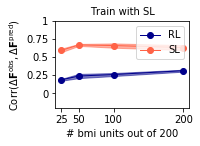

In [9]:
""" Same plot using flow field """
paper = True
save = True

fig,ax = plt.subplots(1,1,figsize=(6,4))

# """ Baseline Result from Main Figure """
# n_samples = len(stats_rflo_m['corr1'])
# mn1 = np.mean(np.asarray(stats_rflo_m['corr1']),axis=0)
# std1 = np.std(np.asarray(stats_rflo_m['corr1']),axis=0)
# sem1 = std1/np.sqrt(n_samples)


""" vary_sig_rec """
n_samples = len(stats_n_units['corr2'])
mn2 = np.mean(np.asarray(stats_n_units['corr2']),axis=0)
std2 = np.std(np.asarray(stats_n_units['corr2']),axis=0)
sem2 = std2/np.sqrt(n_samples)

mn3 = np.mean(np.asarray(stats_n_units['corr3']),axis=0)
std3 = np.std(np.asarray(stats_n_units['corr3']),axis=0)
sem3 = std3/np.sqrt(n_samples)


# plt.plot(overlaps,mn1,'o-',linewidth=1,label=r'$W^{bmi0}$',color='teal')
# plt.fill_between(overlaps,mn1-sem1,mn1+sem1,alpha=0.5,color='teal')

plt.plot(n_bmi_units,mn2,'o-',linewidth=1,label='RL',color='darkblue')
plt.fill_between(n_bmi_units,mn2-sem2,mn2+sem2,alpha=0.5,color='darkblue')

plt.plot(n_bmi_units,mn3,'o-',linewidth=1,label='SL',color='tomato')
plt.fill_between(n_bmi_units,mn3-sem3,mn3+sem3,alpha=0.5,color='tomato')


plt.ylim([-0.2,1])
plt.legend(loc=4)
plt.title('Train with SL')
plt.xlabel('# bmi units out of {}'.format(n_rec))
plt.ylabel('Corr'+r'$(\Delta \mathbf{F}^{\mathrm{obs}}, \Delta \mathbf{F}^{\mathrm{pred}})$')

plt.tight_layout()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=[25,50,100,200],ylabels=[0,0.25,0.5,0.75,1],ticksize=10,linewidth=2,ylim=[-.2,1],figsize=(2.25,3))

plt.show()

if save:
    if paper:
        fig.savefig(folder+'sup-n-bmi-units.pdf')
    else:
        fig.savefig(folder+'sup-n-bmi-units.pdf')
